In this study, we attempt Google stock price prediction using historical data with the aid of GRU (Gated Recurrent Units) neural networks. We perform an extensive tuning of model hyperparameters and also evaluate the effect of wavelet denoising to forecast stock closing prices from one to ten days in future. 

In [1]:
#set seeds for libraries to get reproducible results
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)
import random as python_random
python_random.seed(3)

In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from skimage.util.shape import view_as_windows
pd.options.display.float_format = '{:20,.2f}'.format
import pywt

In [3]:
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('Google_Stock_Price_Train.csv', parse_dates=['Date'],date_parser=dateparse)
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
df.replace(',','',regex=True,inplace=True)
df['Close'] = df['Close'].astype('float')
df['Volume'] = df['Volume'].astype('float')

In [5]:
stocksplit_start = df[df['Date']=='2014-3-27']
correction_end_date = stocksplit_start.index[0]
df.iloc[0:correction_end_date,4] = df.iloc[0:correction_end_date,4].divide(2.001) 

In [7]:
test = pd.read_csv('Google_Stock_Price_Test.csv', parse_dates=['Date'],date_parser=dateparse)

In [8]:
test.replace(',','',regex=True,inplace=True)
test['Volume'] = test['Volume'].astype('float')

In [9]:
trainsize = int(0.80*len(df))
train = df.iloc[:trainsize,:]
valid = df.iloc[trainsize+1::,:]
train.shape,valid.shape

((1006, 6), (251, 6))

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train.iloc[:,1:])
valid_sc = scaler.transform(valid.iloc[:,1:])
print('Shape of scaled train set: {}'.format(train_sc.shape))
print('Shape of scaled validation set: {}'.format(valid_sc.shape))

Shape of scaled train set: (1006, 5)
Shape of scaled validation set: (251, 5)


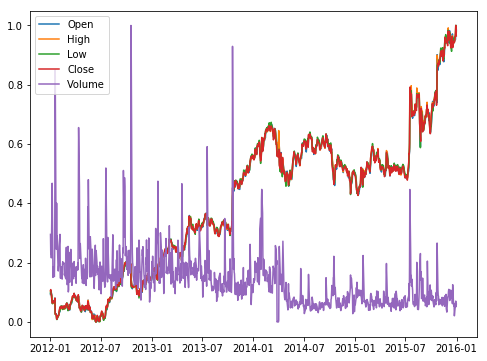

In [102]:
plt.figure(figsize=(8,6))
plt.plot(df.iloc[:trainsize,0],train_sc[:,0], label = 'Open')
plt.plot(df.iloc[:trainsize,0],train_sc[:,1], label = 'High')
plt.plot(df.iloc[:trainsize,0],train_sc[:,2], label = 'Low')
plt.plot(df.iloc[:trainsize,0],train_sc[:,3], label = 'Close')
plt.plot(df.iloc[:trainsize,0],train_sc[:,4], label = 'Volume')
plt.legend();

In [11]:
def wavelet_transform(scaled_data,iterations,wavelet_name):
    scaled_dn = np.empty(shape=scaled_data.shape)
    for i in range(0, scaled_data.shape[1]):
        n = scaled_data[:, i].size
        for j in range(0, iterations):
            coefficients = pywt.wavedec(scaled_data[:, i], wavelet=wavelet_name, mode='symmetric', level=None, axis=0)
            coefficients_transformed = []
            # get the approximation coeffiecients which are not thresholded
            coefficients_transformed.append(coefficients[0])
            # transform the details coefficients by removing the ones more than a full standard deviation away
            for detail_coefficient in coefficients[1:]:
                coefficients_transformed.append(
                    pywt.threshold(detail_coefficient, np.std(detail_coefficient), mode='garrote'))

            temp_array = pywt.waverec(coefficients_transformed, wavelet=wavelet_name, mode='symmetric', axis=0)
            
            scaled_dn[:, i] = temp_array[:n]
    return scaled_dn
train_dB1 = wavelet_transform(train_sc,2,'dB1')
train_haar = wavelet_transform(train_sc,2,'haar')


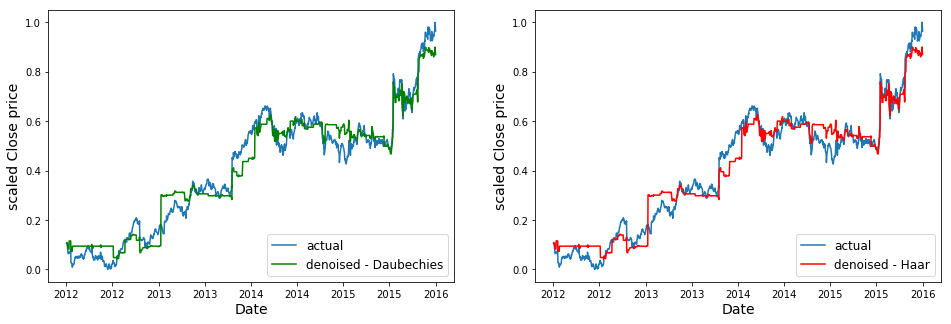

In [105]:
from matplotlib.dates import DateFormatter

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
date_form = DateFormatter("%Y")
ax1.plot(train['Date'],train_sc[:,3],label = 'actual')
ax1.plot(train['Date'],train_dB1[:,3], label = 'denoised - Daubechies', color='green')
ax1.legend(fontsize=12, loc='lower right')
ax1.set_ylabel('scaled Close price', fontsize = 14)
ax1.set_xlabel('Date', fontsize=14)
ax1.xaxis.set_major_formatter(date_form);
ax2.plot(train['Date'],train_sc[:,3],label = 'actual')
ax2.plot(train['Date'],train_haar[:,3],label = 'denoised - Haar',color='red')
ax2.legend(fontsize=12,loc = 'lower right')
ax2.set_ylabel('scaled Close price', fontsize = 14)
ax2.set_xlabel('Date', fontsize=14)
ax2.xaxis.set_major_formatter(date_form);


In [13]:
#consider all features for X, only close feature for y
def create_dataset(dataset_scaled, dataset_scaled_denoised,lookback,lookahead,wavelet_transformation=False):
    if wavelet_transformation == True:
        X = dataset_scaled_denoised
        
    else:
        X = dataset_scaled
    
    n_features = dataset_scaled.shape[1]
    
    y = dataset_scaled[:,3]
     
    dataX = view_as_windows(X, (lookback,n_features))[:-lookahead,0]
    dataY = view_as_windows(y[lookback:,None], (lookahead,1))[:,0]
        
    return dataX,dataY
def plot_history(history, ax=None):
    
    plt.figure(figsize=(8,6))
    if ax is None:
        ax=plt.gca()
        
    # Plot the results (shifting validation curves appropriately)
    ax.set_xlabel('Number of epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    n = len(history.history['loss'])
    ax.plot(np.arange(0,n),history.history['loss'], color='blue', label='Train loss')
    ax.plot(np.arange(0,n),history.history['val_loss'],'green', label='Validation loss')
    ax.legend(frameon=False, fontsize=12)
    return ax

def arrange_daywise(actual_data,prediction_data,lookback,lookahead):
    
    #get actual (true) close values for days used in training and validation
    truevals = actual_data.iloc[lookback:-(lookahead-1),4].values.reshape(-1,1)
    
    #collect 'M' forecasts for each day from prediction data 
    M_arrays = []
    for i in range(lookahead):
        arr = prediction_data[:prediction_data.shape[0]-i,i,0]
        for x in range(i):
            arr = np.insert(arr,[0],np.nan,axis=0)
        M_arrays.append(arr)
    
    M_preds = np.vstack(M_arrays).T
    
    #unscale predicted values
    close_min, close_max = scaler.data_min_[3], scaler.data_max_[3]
    unscale = lambda x: (x*(close_max-close_min)) + close_min
    for M in range(M_preds.shape[1]):
        M_preds[:,M] = unscale(M_preds[:,M])
    
    #stack predicted values for each day with actual values
    M_preds_true = np.hstack((M_preds,truevals))
    
    return M_preds_true


def evaluate_predictions(M_preds_true, column_names):
    #create dataframe of predictions stacked with actual data
    df = pd.DataFrame(M_preds_true,columns = column_names)
    
    #calculate rmse score of each predicted column ('M' forecast) w.r.t actual values
    rmse_scores = []
    for day in range(len(column_names)-1):
        rmse = ((df.iloc[:,day]-df.iloc[:,-1])**2).mean()**0.5
        rmse_scores.append(rmse)
         
    return df,rmse_scores

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional
from tensorflow.keras.layers import GRU,LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [15]:
lookback = 22
lookahead = 5
X_train,y_train = create_dataset(train_sc,_,lookback,lookahead,wavelet_transformation=False)
X_valid,y_valid = create_dataset(valid_sc,_,lookback, lookahead, wavelet_transformation=False)

print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(980, 22, 5) (980, 5, 1)
(225, 22, 5) (225, 5, 1)


/opt/conda/lib/python3.7/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [16]:
lookback=22
lookahead=5
def naive_model(X, M):
    naivepreds =  X[:,-M,3]
    #unscale predicted values
    close_min, close_max = scaler.data_min_[3], scaler.data_max_[3]
    unscale = lambda x: (x*(close_max-close_min)) + close_min
    naivepreds = unscale(naivepreds)
    return naivepreds
naive_scores = []
for M in range(1,lookahead+1):
    train_naivepreds = naive_model(X_train,M)
    truevals = train.iloc[lookback:-(lookahead-1),4].values.reshape(-1,1)
    train_naivepreds
    rmse = math.sqrt(mean_squared_error(train_naivepreds,truevals))
    naive_scores.append(rmse)
print('Baseline Root mean square error...')
print()
for M in range(lookahead):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,naive_scores[M]))
    

Baseline Root mean square error...

Forecasting 1 days ahead (M1): 7.71
Forecasting 2 days ahead (M2): 11.14
Forecasting 3 days ahead (M3): 13.57
Forecasting 4 days ahead (M4): 15.52
Forecasting 5 days ahead (M5): 17.13


In [17]:

valid_naive_scores = []
for M in range(1,lookahead+1):
    valid_naivepreds = naive_model(X_valid,M)
    truevals = valid.iloc[lookback:-(lookahead-1),4].values.reshape(-1,1)
    valid_naivepreds
    rmse = math.sqrt(mean_squared_error(valid_naivepreds,truevals))
    valid_naive_scores.append(rmse)
print('Baseline Root mean square error for validation set...')
print()
for M in range(lookahead):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_naive_scores[M]))
    
    

Baseline Root mean square error for validation set...

Forecasting 1 days ahead (M1): 8.24
Forecasting 2 days ahead (M2): 11.92
Forecasting 3 days ahead (M3): 15.49
Forecasting 4 days ahead (M4): 17.88
Forecasting 5 days ahead (M5): 19.78


In [18]:
#basic model 
model=Sequential()
model.add(GRU(50,input_shape = (lookback,X_train.shape[2])))
model.add(RepeatVector(y_train.shape[1]))
model.add(GRU(50,return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8550      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 50)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 50)             15300     
_________________________________________________________________
dense (Dense)                (None, 5, 1)              51        
Total params: 23,901
Trainable params: 23,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=5, restore_best_weights=True)
history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=50,batch_size=32,verbose=False,callbacks = [es])

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


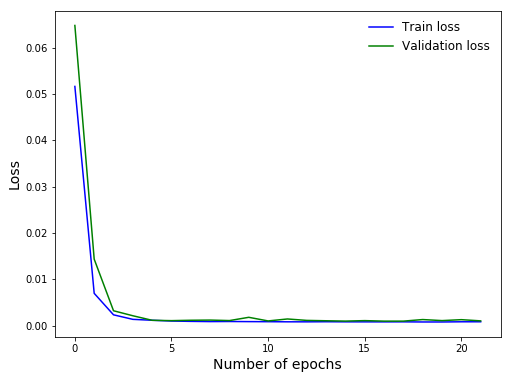

In [104]:
plot_history(history);
#plt.title('Loss curves with basic GRU model', fontsize=16);

In [22]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
traindata = arrange_daywise(train,train_predict,lookback,lookahead)
names = ['M1','M2','M3','M4','M5','Actual']
traindf,train_scores = evaluate_predictions(traindata,names)
validdata = arrange_daywise(valid,valid_predict,lookback,lookahead)
validdf,valid_scores = evaluate_predictions(validdata,names)
traindf.head()

,M1,M2,M3,M4,M5,Actual
0,298.29,nan,nan,nan,nan,297.20
1,300.96,294.16,nan,nan,nan,303.56
2,304.46,297.24,291.35,nan,nan,302.40
3,306.57,301.27,294.64,290.40,nan,303.94
4,308.23,303.76,298.91,293.86,290.26,304.74


In [23]:
traindf.tail()

,M1,M2,M3,M4,M5,Actual
975,766.32,746.97,746.88,744.89,748.37,739.31
976,760.18,748.97,750.45,750.70,747.34,747.77
977,758.55,742.86,752.50,754.21,753.26,750.00
978,761.47,741.88,746.33,756.25,756.72,750.31
979,762.33,744.68,745.11,750.14,758.76,748.40


In [24]:
print('Root mean squared errors for train set...')
print()
for M in range(len(train_scores)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,train_scores[M]))

Root mean squared errors for train set...

Forecasting 1 days ahead (M1): 9.66
Forecasting 2 days ahead (M2): 12.25
Forecasting 3 days ahead (M3): 14.07
Forecasting 4 days ahead (M4): 15.96
Forecasting 5 days ahead (M5): 17.63


In [25]:
print('Root mean squared errors for validation set...')
for M in range(len(valid_scores)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_scores[M]))

Root mean squared errors for validation set...
Forecasting 1 days ahead (M1): 15.44
Forecasting 2 days ahead (M2): 13.20
Forecasting 3 days ahead (M3): 14.76
Forecasting 4 days ahead (M4): 16.40
Forecasting 5 days ahead (M5): 18.14


In [26]:
def model_gru_factory(additional_layers,units,optimizer,learningrate,actfn,initializer):
    model=Sequential()
    model.add(GRU(units=units,input_shape=(lookback,5), dropout=dropout,activation=actfn, kernel_initializer=initializer))
    model.add(RepeatVector(y_train.shape[1]))
    if additional_layers != None:
        for layer in additional_layers:
            model.add(GRU(units,dropout=dropout, activation=actfn,kernel_initializer=initializer))
            model.add(RepeatVector(y_train.shape[1]))
    model.add(GRU(units,return_sequences=True,dropout=dropout, activation=actfn,kernel_initializer=initializer))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer=optimizer(lr=learningrate))
    return model


def do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,batch_size, lookback,lookahead,X):
    model = model_gru_factory(additional_layers,units,optimizer,learningrate,actfn,initializer)
    history = model.fit(X,y_train,epochs=n_epochs,validation_data = (X_valid,y_valid), callbacks=[es])
    trainpred = model.predict(X)
    validpred = model.predict(X_valid)
    traindata = arrange_daywise(train,trainpred,lookback,lookahead)
    validdata = arrange_daywise(valid,validpred,lookback,lookahead)
    traindf,train_scores = evaluate_predictions(traindata,names)
    validdf,valid_scores = evaluate_predictions(validdata,names)
    print("Train RMSE 'M1': {:.2f}, 'M5':{:.2f}".format(train_scores[0],train_scores[-1]))
    print("Validation RMSE 'M1': {:.2f}, 'M5':{:.2f}".format(valid_scores[0],valid_scores[-1]))
    
    return history,model

Epoch 1/50
31/31 [==============================] - 2s 60ms/step - loss: 0.1824 - val_loss: 0.4372
Epoch 2/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0599 - val_loss: 0.1436
Epoch 3/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0201 - val_loss: 0.0653
Epoch 4/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0156 - val_loss: 0.0559
Epoch 5/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0140 - val_loss: 0.0505
Epoch 6/50
31/31 [==============================] - 1s 27ms/step - loss: 0.0125 - val_loss: 0.0440
Epoch 7/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0110 - val_loss: 0.0380
Epoch 8/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0097 - val_loss: 0.0325
Epoch 9/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0084 - val_loss: 0.0266
Epoch 10/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0072 - val_loss: 0.0222
Epoch 11/

Epoch 2/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/50
31/31 [==============================] - 1s 29ms/step - loss: 8.6385e-04 - val_loss: 8.8128e-04
Epoch 4/50
31/31 [==============================] - 1s 28ms/step - loss: 8.5424e-04 - val_loss: 8.7388e-04
Epoch 5/50
31/31 [==============================] - 1s 31ms/step - loss: 8.2126e-04 - val_loss: 8.5231e-04
Epoch 6/50
31/31 [==============================] - 1s 29ms/step - loss: 9.0448e-04 - val_loss: 8.8278e-04
Epoch 7/50
31/31 [==============================] - 1s 31ms/step - loss: 0.0010 - val_loss: 8.7668e-04
Epoch 8/50
31/31 [==============================] - 1s 33ms/step - loss: 9.1111e-04 - val_loss: 0.0010
Epoch 9/50
31/31 [==============================] - 1s 29ms/step - loss: 7.8927e-04 - val_loss: 8.4221e-04
Epoch 10/50
31/31 [==============================] - 1s 29ms/step - loss: 7.8958e-04 - val_loss: 8.9700e-04
Epoch 11/50
31/31 [==============================] -

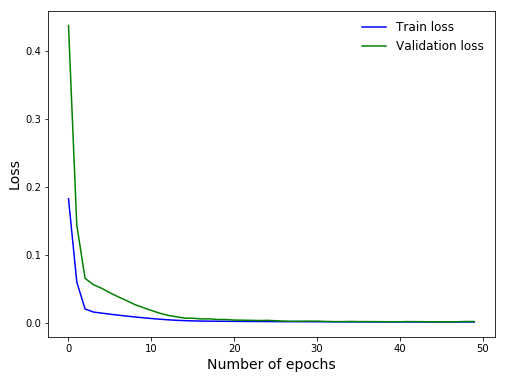

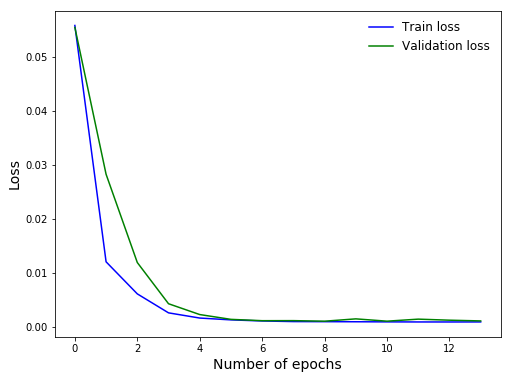

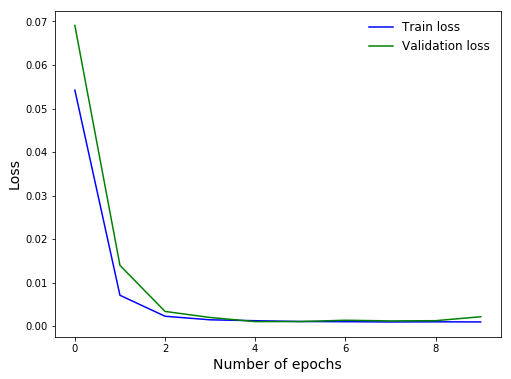

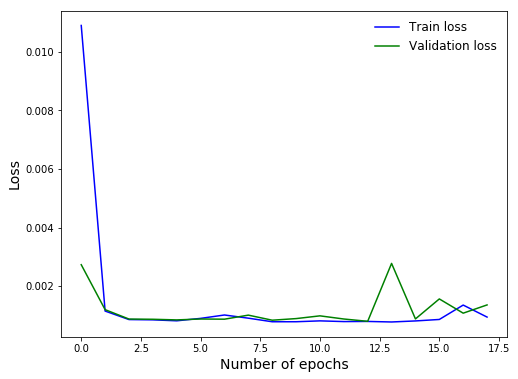

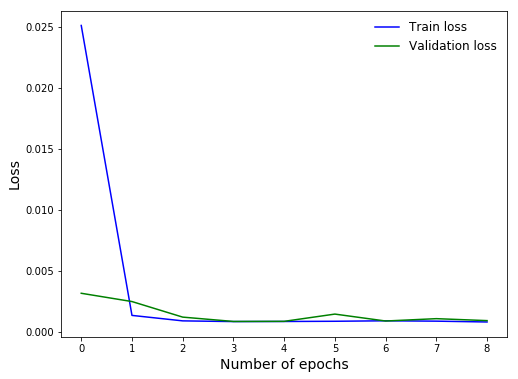

In [27]:
additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.001
actfn = 'tanh'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
lr_multiple = [0.1,0.5,1,5,10]
models1 = []
for lr in lr_multiple:
    outputs = do_all_gru(additional_layers,units,optimizer,learningrate*lr,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train)
    plot_history(outputs[0])
    models1.append(outputs[1])

Epoch 1/50
31/31 [==============================] - 1s 48ms/step - loss: 0.0132 - val_loss: 0.0026
Epoch 2/50
31/31 [==============================] - 1s 29ms/step - loss: 9.4127e-04 - val_loss: 0.0013
Epoch 3/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/50
31/31 [==============================] - 1s 28ms/step - loss: 9.6508e-04 - val_loss: 9.7424e-04
Epoch 5/50
31/31 [==============================] - 1s 28ms/step - loss: 8.2994e-04 - val_loss: 8.1787e-04
Epoch 6/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 7/50
31/31 [==============================] - 1s 28ms/step - loss: 9.4913e-04 - val_loss: 8.2071e-04
Epoch 8/50
31/31 [==============================] - 1s 28ms/step - loss: 8.8958e-04 - val_loss: 9.3844e-04
Epoch 9/50
31/31 [==============================] - 1s 28ms/step - loss: 7.9649e-04 - val_loss: 7.9913e-04
Epoch 10/50
31/31 [==============================] - 1s 27ms/step

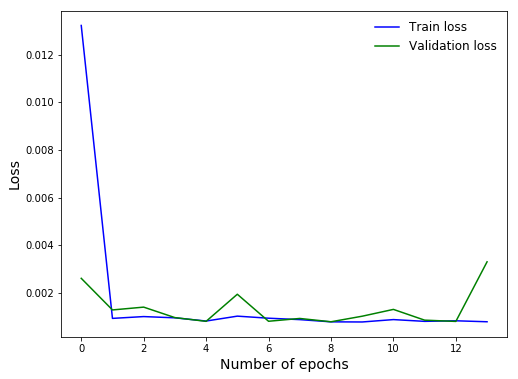

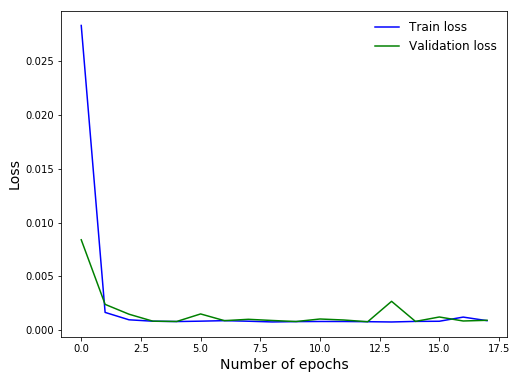

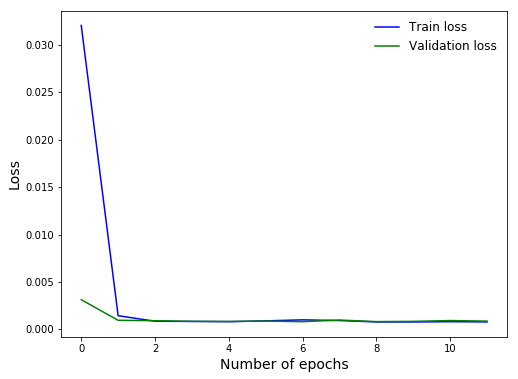

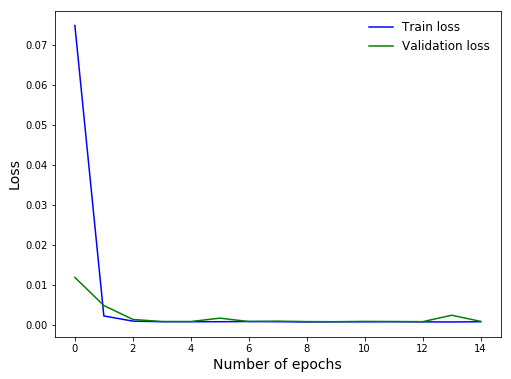

In [28]:
additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.001
actfn = 'tanh'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
lr_multiple = [7.5,10,12.5,15]
models2 = []
for lr in lr_multiple:
    outputs = do_all_gru(additional_layers,units,optimizer,learningrate*lr,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train)
    plot_history(outputs[0])
    models2.append(outputs[1])

In [29]:
#increase units to further improve model training
additional_layers = None
units = 100
optimizer = optimizers.Adam
learningrate = 0.0125 
actfn = 'tanh'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
history3,model3 = do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train)

Epoch 1/50
31/31 [==============================] - 2s 51ms/step - loss: 0.1194 - val_loss: 0.0132
Epoch 2/50
31/31 [==============================] - 2s 59ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/50
31/31 [==============================] - 1s 32ms/step - loss: 9.4330e-04 - val_loss: 0.0012
Epoch 4/50
31/31 [==============================] - 1s 31ms/step - loss: 8.4119e-04 - val_loss: 0.0012
Epoch 5/50
31/31 [==============================] - 1s 31ms/step - loss: 8.5993e-04 - val_loss: 0.0010
Epoch 6/50
31/31 [==============================] - 1s 30ms/step - loss: 8.6322e-04 - val_loss: 0.0016
Epoch 7/50
31/31 [==============================] - 1s 31ms/step - loss: 8.6653e-04 - val_loss: 9.9466e-04
Epoch 8/50
31/31 [==============================] - 1s 30ms/step - loss: 8.1737e-04 - val_loss: 8.7342e-04
Epoch 9/50
31/31 [==============================] - 1s 31ms/step - loss: 7.8652e-04 - val_loss: 9.7042e-04
Epoch 10/50
31/31 [==============================] - 1s 30ms/step - l

#### denoted as Model2 in report

In [30]:
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_20 (GRU)                 (None, 100)               32100     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 5, 100)            0         
_________________________________________________________________
gru_21 (GRU)                 (None, 5, 100)            60600     
_________________________________________________________________
dense_10 (Dense)             (None, 5, 1)              101       
Total params: 92,801
Trainable params: 92,801
Non-trainable params: 0
_________________________________________________________________


In [31]:
#increase number of hidden layers improve model training
additional_layers = [1]
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125 
actfn = 'tanh'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
history4,model4 = do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train)

Epoch 1/50
31/31 [==============================] - 2s 68ms/step - loss: 0.0359 - val_loss: 0.0019
Epoch 2/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/50
31/31 [==============================] - 1s 37ms/step - loss: 9.5969e-04 - val_loss: 0.0010
Epoch 4/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 8.7378e-04
Epoch 5/50
31/31 [==============================] - 1s 37ms/step - loss: 9.1340e-04 - val_loss: 0.0015
Epoch 6/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/50
31/31 [==============================] - 1s 37ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 8/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0011 - val_loss: 8.1459e-04
Epoch 9/50
31/31 [==============================] - 1s 46ms/step - loss: 9.6315e-04 - val_loss: 0.0012
Epoch 10/50
31/31 [==============================] - 1s 35ms/step - loss: 8.6946e-04 - va

#### denoted as Model3 in report

In [32]:
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 50)                8550      
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
gru_23 (GRU)                 (None, 50)                15300     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
gru_24 (GRU)                 (None, 5, 50)             15300     
_________________________________________________________________
dense_11 (Dense)             (None, 5, 1)              51        
Total params: 39,201
Trainable params: 39,201
Non-trainable params: 0
_________________________________________________

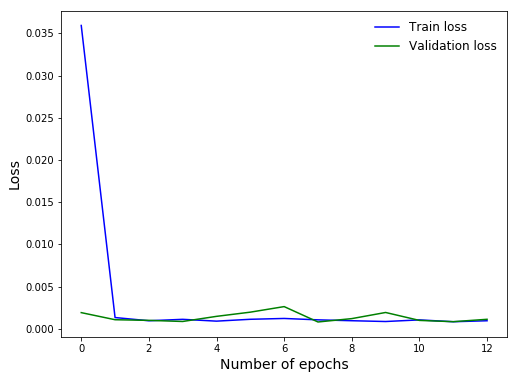

In [33]:
plot_history(history4)

Epoch 1/50
31/31 [==============================] - 2s 50ms/step - loss: 0.0209 - val_loss: 0.0071
Epoch 2/50
31/31 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/50
31/31 [==============================] - 1s 28ms/step - loss: 8.7026e-04 - val_loss: 9.8658e-04
Epoch 4/50
31/31 [==============================] - 1s 29ms/step - loss: 8.7615e-04 - val_loss: 8.2464e-04
Epoch 5/50
31/31 [==============================] - 1s 28ms/step - loss: 8.3247e-04 - val_loss: 9.0447e-04
Epoch 6/50
31/31 [==============================] - 1s 28ms/step - loss: 9.2982e-04 - val_loss: 8.3076e-04
Epoch 7/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0010 - val_loss: 9.3503e-04
Epoch 8/50
31/31 [==============================] - 1s 27ms/step - loss: 0.0010 - val_loss: 9.9251e-04
Epoch 9/50
31/31 [==============================] - 1s 28ms/step - loss: 8.0580e-04 - val_loss: 8.0119e-04
Epoch 10/50
31/31 [==============================] - 1s 28ms/

31/31 [==============================] - 1s 22ms/step - loss: 8.0293e-04 - val_loss: 8.1586e-04
Epoch 14/50
31/31 [==============================] - 1s 24ms/step - loss: 7.8435e-04 - val_loss: 0.0028
Epoch 00014: early stopping
Train RMSE 'M1': 8.44, 'M5':17.13
Validation RMSE 'M1': 8.57, 'M5':17.82
Epoch 1/50
31/31 [==============================] - 1s 35ms/step - loss: 0.1341 - val_loss: 0.0028
Epoch 2/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 9.3978e-04 - val_loss: 0.0012
Epoch 4/50
31/31 [==============================] - 1s 25ms/step - loss: 8.3486e-04 - val_loss: 8.9554e-04
Epoch 5/50
31/31 [==============================] - 1s 25ms/step - loss: 8.6001e-04 - val_loss: 0.0012
Epoch 6/50
31/31 [==============================] - 1s 25ms/step - loss: 8.5293e-04 - val_loss: 8.6046e-04
Epoch 7/50
31/31 [==============================] - 1s 25ms/step - loss: 8.1206e-

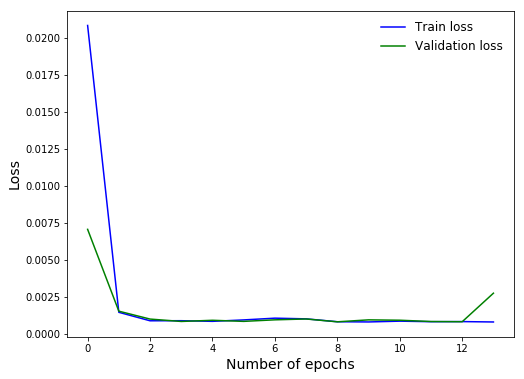

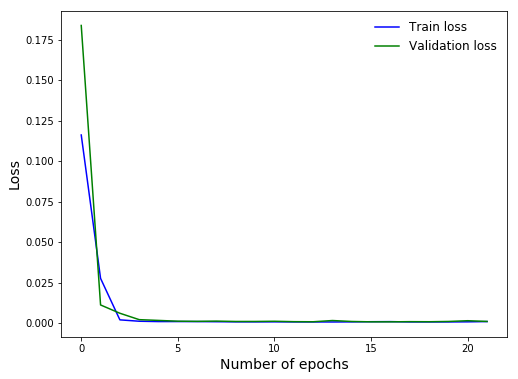

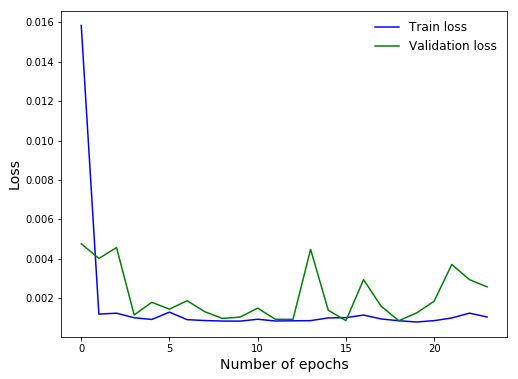

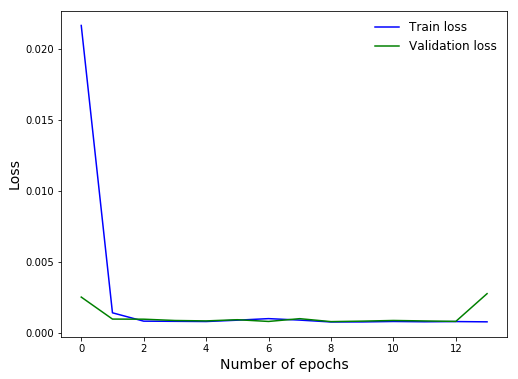

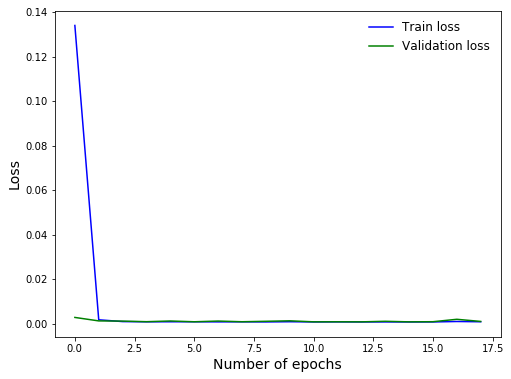

In [34]:
additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125
actfn = ['tanh','sigmoid','relu','elu','selu']
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
models6 = []
for act in actfn:
    outputs = do_all_gru(additional_layers,units,optimizer,learningrate,act,initializer,n_epochs,batch_size,lookback,lookahead,X_train)
    plot_history(outputs[0])
    models6.append(outputs[1])

In [37]:
X_train_dB1,y_train = create_dataset(train_sc,train_dB1,lookback,lookahead,wavelet_transformation=True)
X_valid,y_valid = create_dataset(valid_sc,_,lookback, lookahead, wavelet_transformation=False)


additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125
actfn = 'elu'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
history7,model7 = do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train_dB1)

Epoch 1/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0251 - val_loss: 0.0010
Epoch 2/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 3/50
31/31 [==============================] - 1s 26ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 4/50
31/31 [==============================] - 1s 32ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 5/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 6/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0033 - val_loss: 0.0083
Epoch 00006: early stopping
Train RMSE 'M1': 30.22, 'M5':32.22
Validation RMSE 'M1': 13.78, 'M5':18.79


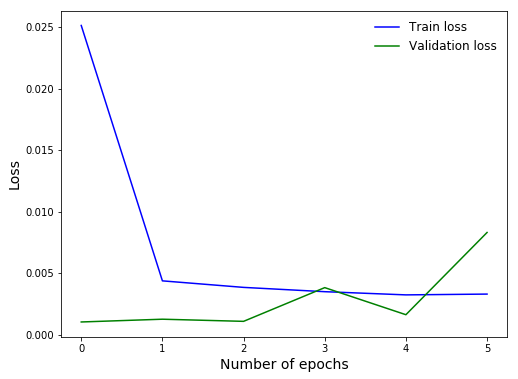

In [38]:
plot_history(history7);

In [39]:
X_train_haar,y_train = create_dataset(train_sc,train_haar,lookback,lookahead,wavelet_transformation=True)
X_valid,y_valid = create_dataset(valid_sc,_,lookback, lookahead, wavelet_transformation=False)


additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125
actfn = 'elu'
initializer='glorot_uniform'
n_epochs = 50
batch_size=32
dropout=0.0
lookback=22
lookahead=5
history8,model8 = do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,batch_size,lookback,lookahead,X_train_haar)

Epoch 1/50
31/31 [==============================] - 1s 36ms/step - loss: 0.0396 - val_loss: 0.0089
Epoch 2/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/50
31/31 [==============================] - 1s 26ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 4/50
31/31 [==============================] - 1s 30ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 5/50
31/31 [==============================] - 1s 31ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0033 - val_loss: 0.0081
Epoch 7/50
31/31 [==============================] - 1s 26ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 8/50
31/31 [==============================] - 1s 23ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 00008: early stopping
Train RMSE 'M1': 28.16, 'M5':30.95
Validation RMSE 'M1': 22.52, 'M5':19.01


Epoch 1/50
31/31 [==============================] - 1s 36ms/step - loss: 0.0551 - val_loss: 0.0082
Epoch 2/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/50
31/31 [==============================] - 1s 25ms/step - loss: 8.6099e-04 - val_loss: 0.0010
Epoch 5/50
31/31 [==============================] - 1s 24ms/step - loss: 8.1872e-04 - val_loss: 9.0263e-04
Epoch 6/50
31/31 [==============================] - 1s 24ms/step - loss: 8.4373e-04 - val_loss: 0.0020
Epoch 7/50
31/31 [==============================] - 1s 24ms/step - loss: 8.9984e-04 - val_loss: 0.0012
Epoch 8/50
31/31 [==============================] - 1s 24ms/step - loss: 8.6010e-04 - val_loss: 9.7407e-04
Epoch 9/50
31/31 [==============================] - 1s 25ms/step - loss: 7.8272e-04 - val_loss: 8.5714e-04
Epoch 10/50
31/31 [==============================] - 1s 25ms/step - loss:

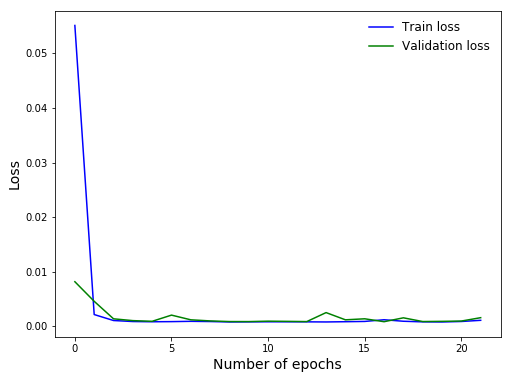

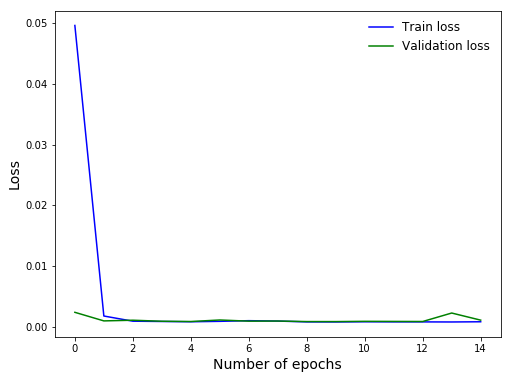

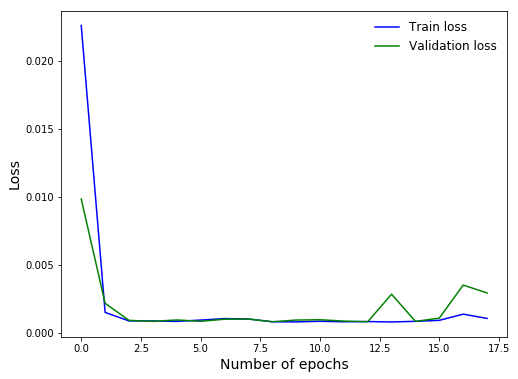

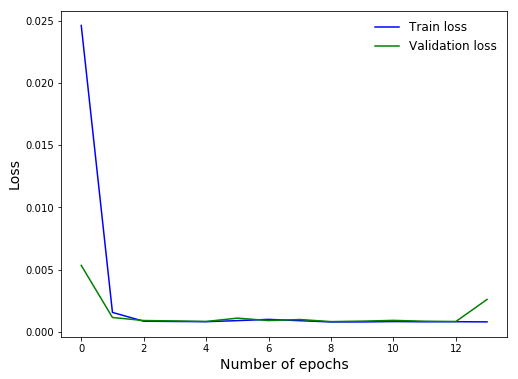

In [40]:
additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125
actfn = 'elu'
initializer='glorot_uniform'
n_epochs = 50
batch_sizes=[16,32,64,128]
dropout=0.0
lookback=22
lookahead=5
models9 = []
for bs in batch_sizes:
    outputs = do_all_gru(additional_layers,units,optimizer,learningrate,actfn,initializer,n_epochs,bs,lookback,lookahead,X_train)
    plot_history(outputs[0])
    models9.append(outputs[1])

In [41]:
#best model
best_model = models9[3]
trainpreds = best_model.predict(X_train)
validpreds = best_model.predict(X_valid)
traindata2 = arrange_daywise(train,trainpreds,lookback,lookahead)
names = ['M1','M2','M3','M4','M5','Actual']
traindf2,train_scores2 = evaluate_predictions(traindata2,names)
validdata2 = arrange_daywise(valid,validpreds,lookback,lookahead)
validdf2,valid_scores2 = evaluate_predictions(validdata2,names)


In [42]:
print('Root mean squared errors for train set using best model...')
print()
for M in range(len(train_scores)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,train_scores2[M]))

Root mean squared errors for train set using best model...

Forecasting 1 days ahead (M1): 8.34
Forecasting 2 days ahead (M2): 11.45
Forecasting 3 days ahead (M3): 13.73
Forecasting 4 days ahead (M4): 15.61
Forecasting 5 days ahead (M5): 17.18


In [43]:
print('Root mean squared errors for validation set using best model...')
for M in range(len(valid_scores)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_scores2[M]))

Root mean squared errors for validation set using best model...
Forecasting 1 days ahead (M1): 8.65
Forecasting 2 days ahead (M2): 11.85
Forecasting 3 days ahead (M3): 14.56
Forecasting 4 days ahead (M4): 16.36
Forecasting 5 days ahead (M5): 17.84


In [44]:
print('Baseline Root mean square error for validation set...')
print()
for M in range(5):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_naive_scores[M]))
    
    

Baseline Root mean square error for validation set...

Forecasting 1 days ahead (M1): 8.24
Forecasting 2 days ahead (M2): 11.92
Forecasting 3 days ahead (M3): 15.49
Forecasting 4 days ahead (M4): 17.88
Forecasting 5 days ahead (M5): 19.78


## Forecasting 10 days ahead

In [45]:
lookback = 22
lookahead = 10
X_train10,y_train10 = create_dataset(train_sc,_,lookback,lookahead,wavelet_transformation=False)
X_valid10,y_valid10 = create_dataset(valid_sc,_,lookback, lookahead, wavelet_transformation=False)

print(X_train10.shape,y_train10.shape)
print(X_valid10.shape,y_valid10.shape)

(975, 22, 5) (975, 10, 1)
(220, 22, 5) (220, 10, 1)


In [82]:
additional_layers = None
units = 50
optimizer = optimizers.Adam
learningrate = 0.0125
actfn = 'elu'
initializer='glorot_uniform'
n_epochs = 50
batch_size=64
dropout=0.0
lookback=22
lookahead=10
names10 = ['M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','Actual']

model10=Sequential()
model10.add(GRU(50,input_shape = (lookback,X_train10.shape[2]),activation=actfn,kernel_initializer=initializer))
model10.add(RepeatVector(y_train10.shape[1]))
model10.add(GRU(50,return_sequences=True,activation=actfn,kernel_initializer=initializer ))
model10.add(Dense(1))
model10.compile(loss='mean_squared_error',optimizer='adam')


history10 = model10.fit(X_train10,y_train10,validation_data=(X_valid10,y_valid10),epochs=50,batch_size=batch_size,
                        verbose=False,callbacks = [es])

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


In [84]:
trainpreds = model10.predict(X_train10)
validpreds = model10.predict(X_valid10)
traindata3 = arrange_daywise(train,trainpreds,lookback,lookahead)
traindf3,train_scores3 = evaluate_predictions(traindata3,names)
validdata3 = arrange_daywise(valid,validpreds,lookback,lookahead)
validdf3,valid_scores3 = evaluate_predictions(validdata3,names10)
print('Root mean squared errors for train set using best model...')
print()
for M in range(len(train_scores3)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,train_scores3[M]))

Root mean squared errors for train set using best model...

Forecasting 1 days ahead (M1): 13.72
Forecasting 2 days ahead (M2): 18.20
Forecasting 3 days ahead (M3): 16.65
Forecasting 4 days ahead (M4): 17.11
Forecasting 5 days ahead (M5): 18.33
Forecasting 6 days ahead (M6): 19.58
Forecasting 7 days ahead (M7): 20.75
Forecasting 8 days ahead (M8): 21.80
Forecasting 9 days ahead (M9): 22.77
Forecasting 10 days ahead (M10): 23.71


In [85]:
print('Root mean squared errors for validation set using best model...')
for M in range(len(valid_scores3)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_scores3[M]))

Root mean squared errors for validation set using best model...
Forecasting 1 days ahead (M1): 12.81
Forecasting 2 days ahead (M2): 14.82
Forecasting 3 days ahead (M3): 15.11
Forecasting 4 days ahead (M4): 16.81
Forecasting 5 days ahead (M5): 18.29
Forecasting 6 days ahead (M6): 19.64
Forecasting 7 days ahead (M7): 20.91
Forecasting 8 days ahead (M8): 22.03
Forecasting 9 days ahead (M9): 23.13
Forecasting 10 days ahead (M10): 24.00


In [86]:
valid_naive_scores = []
for M in range(1,lookahead+1):
    valid_naivepreds = naive_model(X_valid10,M)
    truevals = valid.iloc[lookback:-(lookahead-1),4].values.reshape(-1,1)
    
    rmse = math.sqrt(mean_squared_error(valid_naivepreds,truevals))
    valid_naive_scores.append(rmse)
print('Baseline Root mean square error for validation set...')
print()
for M in range(lookahead):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,valid_naive_scores[M]))
    
    

Baseline Root mean square error for validation set...

Forecasting 1 days ahead (M1): 8.33
Forecasting 2 days ahead (M2): 12.04
Forecasting 3 days ahead (M3): 15.66
Forecasting 4 days ahead (M4): 18.08
Forecasting 5 days ahead (M5): 20.00
Forecasting 6 days ahead (M6): 21.39
Forecasting 7 days ahead (M7): 22.83
Forecasting 8 days ahead (M8): 23.97
Forecasting 9 days ahead (M9): 24.83
Forecasting 10 days ahead (M10): 25.51


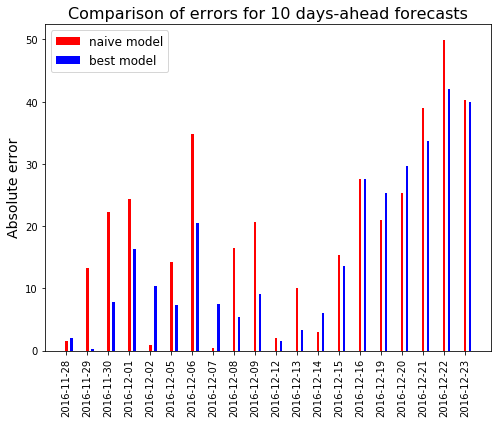

In [107]:
#compare daywise errors for naive and best model 10 day forecast
naive_10dayforecast = naive_model(X_valid10,10).reshape(-1,1)
bestmodel_10dayforecast = validdf3.iloc[:,-2].values.reshape(-1,1)
truevals = validdf3.iloc[:,-1].values.reshape(-1,1)
dates =  valid.iloc[lookback:-(lookahead-1),0]

#calculate differences for last 20 days

naive_actual = np.abs(naive_10dayforecast[-20:,0]-truevals[-20:,0])
bestmodel_actual = np.abs(bestmodel_10dayforecast[-20:,0]-truevals[-20:,0])
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(naive_actual))
width = 0.12 
ax.bar(x, naive_actual, width, label='naive model', color='red');
ax.bar(x+ 2*width, bestmodel_actual, width, label='best model', color='blue')
ax.set_xticks(x)
#date_form = DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(date_form)
ax.set_xticklabels(dates.iloc[-20:].dt.date, rotation='vertical')
ax.set_ylabel('Absolute error', fontsize = 14 )
plt.title('Comparison of errors for 10 days-ahead forecasts', fontsize=16)
plt.legend(fontsize=12);


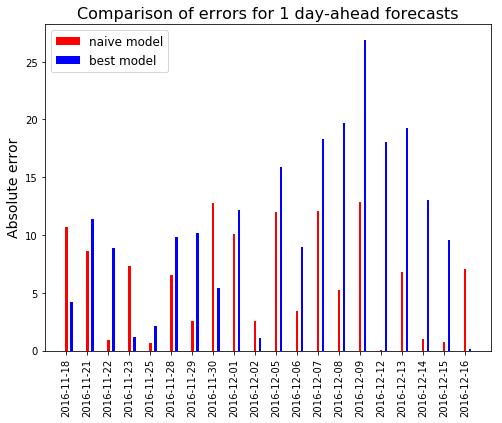

In [88]:
#compare daywise errors for naive and best model 10 day forecast
naive_1dayforecast = naive_model(X_valid10,1).reshape(-1,1)
bestmodel_1dayforecast = validdf3.iloc[:,0].values.reshape(-1,1)
truevals = validdf3.iloc[:,-1].values.reshape(-1,1)
dates =  valid.iloc[lookback:-(lookahead-1),0]

#calculate differences for last 20 days
naive_actual = np.abs(naive_1dayforecast[-20:,0]-truevals[-20:,0])
bestmodel_actual = np.abs(bestmodel_1dayforecast[-20:,0]-truevals[-20:,0])
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(naive_actual))
width = 0.12 
ax.bar(x, naive_actual, width, label='naive model', color='red');
ax.bar(x+ 2*width, bestmodel_actual, width, label='best model', color='blue')
ax.set_xticks(x)
#date_form = DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(date_form)
ax.set_xticklabels(dates.iloc[-20:].dt.date, rotation='vertical')
ax.set_ylabel('Absolute error', fontsize = 14 )
plt.title('Comparison of errors for 1 day-ahead forecasts', fontsize=16)
plt.legend(fontsize=12, loc='upper left');



In [89]:
#evaluate test dataset
valid_tail22 = valid.iloc[-22:,:]
test_merged = pd.concat([valid_tail22,test]).reset_index(drop=True)

In [111]:
test_sc = scaler.transform(test_merged.iloc[:,1:])
test_sc
X_test,y_test = create_dataset(test_sc,_,lookback=22,lookahead=10,wavelet_transformation=False)


/opt/conda/lib/python3.7/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(11, 22, 5)

In [113]:
lookahead=10
testpreds = model10.predict(X_test)
testdata = arrange_daywise(test_merged,testpreds,lookback=22,lookahead=10)
testdf,test_scores = evaluate_predictions(testdata,names10)

print('Root mean squared errors for test set using best model...')
print()
for M in range(len(test_scores)):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,test_scores[M]))

Root mean squared errors for test set using best model...

Forecasting 1 days ahead (M1): 10.99
Forecasting 2 days ahead (M2): 6.97
Forecasting 3 days ahead (M3): 15.08
Forecasting 4 days ahead (M4): 17.48
Forecasting 5 days ahead (M5): 18.61
Forecasting 6 days ahead (M6): 20.53
Forecasting 7 days ahead (M7): 23.11
Forecasting 8 days ahead (M8): 24.82
Forecasting 9 days ahead (M9): 26.14
Forecasting 10 days ahead (M10): 26.19


In [114]:
lookahead=10
test_naive_scores = []
for M in range(1,lookahead+1):
    test_naivepreds = naive_model(X_test,M)
    truevals = test_merged.iloc[lookback:-(lookahead-1),4].values.reshape(-1,1)
    
    rmse = math.sqrt(mean_squared_error(test_naivepreds,truevals))
    test_naive_scores.append(rmse)
print('Baseline Root mean square error for test set...')
print()
for M in range(lookahead):
    print('Forecasting {} days ahead (M{}): {:.2f}'.format(M+1,M+1,test_naive_scores[M]))
    
    

Baseline Root mean square error for test set...

Forecasting 1 days ahead (M1): 6.28
Forecasting 2 days ahead (M2): 8.75
Forecasting 3 days ahead (M3): 11.45
Forecasting 4 days ahead (M4): 14.38
Forecasting 5 days ahead (M5): 16.03
Forecasting 6 days ahead (M6): 17.03
Forecasting 7 days ahead (M7): 17.92
Forecasting 8 days ahead (M8): 18.61
Forecasting 9 days ahead (M9): 18.88
Forecasting 10 days ahead (M10): 17.83
